In [ ]:
import os
#os.chdir('/content/drive/MyDrive/invoice data extraction/')
os.listdir()

# Install Packages

In [ ]:
!sudo apt-get install tesseract-ocr
!pip -q install pytesseract
!pip install --user easyocr -q
!pip -q install faiss-cpu
!pip install --upgrade typing_extensions -q
!pip -q install datasets
!pip -q install pillow transformers torch openpyxl
!pip install transformers torchvision -q
!pip install timm -q

In [4]:
from PIL import Image
import os
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer, RagRetriever, RagTokenForGeneration
from datasets import Dataset
import cv2
import numpy as np

# Data Processing

In [ ]:
image_dir_r = 'train/receipt'
image_dir_i = 'train/invoice'
output_dir = 'structured_data/invoice'  
os.makedirs(output_dir, exist_ok=True)

In [6]:
def count_files_in_directory(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

file_count_i = count_files_in_directory(image_dir_i)
file_count_r = count_files_in_directory(image_dir_r)
print(f"Number of invoice images: {file_count_i}")
print(f"Number of invoice receipt: {file_count_r}")

Number of invoice images: 2700
Number of invoice receipt: 2694


## Image Processing

In [1]:
import cv2
import numpy as np

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    scale = max(400 / h, 400 / w)
    if scale > 1:
        img = cv2.resize(img, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_CUBIC)

    img = cv2.GaussianBlur(img, (3, 3), 0)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    contrast = clahe.apply(gray)

    coords = np.column_stack(np.where(contrast > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    if 1.5 <= abs(angle) <= 15:
        (h, w) = contrast.shape
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        contrast = cv2.warpAffine(contrast, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    thresh = cv2.threshold(contrast, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(np.vstack(contours))
        cropped = contrast[y:y + h, x:x + w]
    else:
        cropped = contrast

    return cropped

In [2]:
import cv2
import numpy as np
import easyocr

reader = easyocr.Reader(['en'], gpu=False)

def extract_single_table_region_per_image(images, min_words=3):

    final_crops = []

    for img in images:
        _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
        dilated = cv2.dilate(binary, kernel, iterations=1)

        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cropped_rows = []

        for c in sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1]):
            x, y, w, h = cv2.boundingRect(c)
            if h > 15 and w > 50:
                cropped = img[y:y+h, x:x+w]
                cropped_rows.append((cropped, w * h))  # include area for fallback

        # Score based on OCR word count
        best_crop = None
        max_words = 0

        for crop, _ in cropped_rows:
            result = reader.readtext(crop, detail=0, paragraph=False)
            if len(result) > max_words:
                max_words = len(result)
                best_crop = crop

        if best_crop is not None and max_words >= min_words:
            final_crops.append(best_crop)
        elif cropped_rows:
            fallback_crop = max(cropped_rows, key=lambda x: x[1])[0]
            final_crops.append(fallback_crop)
        else:
            final_crops.append(img)

    return final_crops  # One image per input


Using CPU. Note: This module is much faster with a GPU.


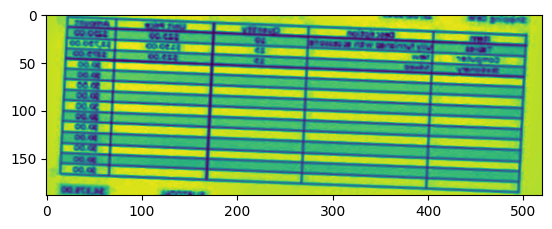

In [117]:
import matplotlib.pyplot as plt

plt.imshow(table_rows[4])  
plt.show()

## Text extraction

In [118]:
import easyocr
import tempfile

In [119]:
def extract_text_from_cropped_image(cropped_img):
    reader = easyocr.Reader(['en'])
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
    cv2.imwrite(temp_file.name, cropped_img)

    results = reader.readtext(temp_file.name)
    text = " ".join([result[1] for result in results])

    temp_file.close()
    os.remove(temp_file.name)

    return text

## Text processing


In [121]:
import re

def preprocess_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(' +', ' ', text).strip()
    text = re.sub(r'[^a-zA-Z0-9.,: ]', '', text)
    text = text.lower()

    return text

In [ ]:
processed_text = preprocess_text(extract_text)
print(preprocess_text)

<function preprocess_text at 0x000001A8488CB4C0>


# GPT4All


In [1]:
from gpt4all import GPT4All
model = GPT4All("Meta-Llama-3-8B-Instruct.Q4_0.gguf")

In [ ]:
#sample generation
with model.chat_session():
    print(model.generate(processed_text, max_tokens=1024))

In [2]:
def finetune_gpt4all(extracted_data):

    prompt = f'''Construct csv  with the following data: {extracted_data}. The data is extracted text from a invoice table. Return the table as a strict csv. Strickly Do nott give any comments, just return the csv. below is an example of how the value is supposed to returned
        coloumn1, coloumn2...<newline symbol>
        value1_1, value2_1...<newline symbol>
        value1_2, value2_2...<newline symbol>
    '''
    with model.chat_session():
        response = model.generate(prompt, max_tokens=1024)
    return response

In [ ]:
import csv

def save_to_csv(structured_data, filename="output.csv"):
    if not structured_data.get("Invoice Details"):
        print("No invoice data found.")
        return
    
    invoice_list = structured_data["Invoice Details"]

    cleaned_data = []
    for invoice in invoice_list:
        cleaned_invoice = {
            k: v for k, v in invoice.items() 
            if not k.strip().isdigit() and len(k.strip()) > 2
        }
        cleaned_data.append(cleaned_invoice)

    headers = set()
    for item in cleaned_data:
        headers.update(item.keys())

    headers = list(headers)

    with open(filename, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writeheader()
        writer.writerows(cleaned_data)

    print(f"Data saved to {filename}")
